# Minimal example

In this notebook we show how to interface [pyABC](https://github.com/icb-dcm/pyabc) with the [Morpheus](https://morpheus.gitlab.io/) toolbox.

In [1]:
import pyabc
import fitmulticell as fmc
import scipy as sp
import numpy as np
import pandas as pd
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt

A Morpheus model is created by passing a Morpheus XML file to the ``fmc.model.MorpheusModel`` class. Here wew need to specify the mapping of parameters to xpaths in the model file, to tell pyABC where to put parameters in the model.

In [2]:
file_ = "MAPK_SBML.xml"
par_map = {'V1': './CellTypes/CellType/System/Constant[@symbol="V1"]',
           'V2': './CellTypes/CellType/System/Constant[@symbol="V2"]',
           'k3': './CellTypes/CellType/System/Constant[@symbol="k3"]'}
model = fmc.model.MorpheusModel(
    file_, par_map=par_map,
    executable="ch-run ../../morpheus_docker -- /usr/bin/morpheus",
    show_stdout=False, show_stderr=True,
    raise_on_error=False)

print(model)

MorpheusModel {
	name      : MAPK_SBML.xml
}


Let us generate some dummy observed data. Therefore, we sample from true parameters. The returned value contains a link to a folder which has been newly created to accommodate all simulation files. By default, that folder is in the system's temporary folders, but that can also be customized.

The paramters we define here must correspond to Constants in the Morpheus XML file.

In [3]:
true_pars = {'V1': 2.7, 'V2': 0.25, 'k3': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)

Here, we specified the output to be a dictionary object. The output format can also be customized.

As usual, we have to define a prior for our parameters. Also, we have to define a distance which computes a 1-dim value from the generated data. Note that also this step can be customized, e.g. for arbitrary summary statistics.

In [4]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(val1, val2):
    d = np.sum([np.sum(np.abs(val1[key] - val2[key])) \
                for key in ['IdSumstat__MAPK_P', 'IdSumstat__MKK_P']])
    return d

Now, we are able to run our ABC analysis as usual. The ``pyabc.external`` classes take care of all calls to the external simulator.

In [5]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=20)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)

INFO:History:Start <ABCSMC(id=33, start_time=2019-10-10 03:51:47.324195, end_time=None)>


In [6]:
abc.run(max_nr_populations=5)

INFO:Epsilon:initial epsilon is 14263.750449443902
INFO:ABC:t:0 eps:14263.750449443902
INFO:ABC:t:1 eps:12296.3671979855
INFO:ABC:t:2 eps:9190.914354211447
INFO:ABC:t:3 eps:5705.259305071802
INFO:ABC:t:4 eps:3653.39795037645
INFO:History:Done <ABCSMC(id=33, start_time=2019-10-10 03:51:47.324195, end_time=2019-10-10 03:52:07.063423)>


We can also plot some results to see what pyABC did.

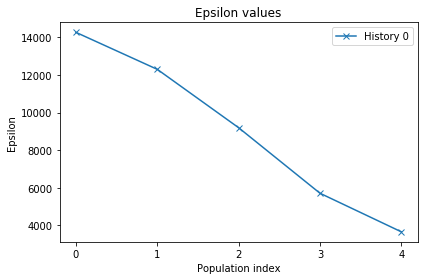

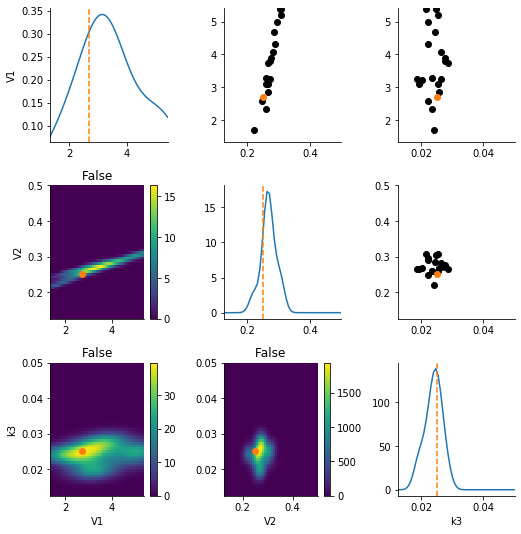

In [7]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()